F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Model Accuracy: nan
Test Accuracy: 0.61
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        16
         1.0       0.33      0.29      0.31         7

    accuracy                           0.61        23
   macro avg       0.52      0.52      0.52        23
weighted avg       0.59      0.61      0.60        23



F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\gradio\interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Keyboard interruption in main thread... closing server.


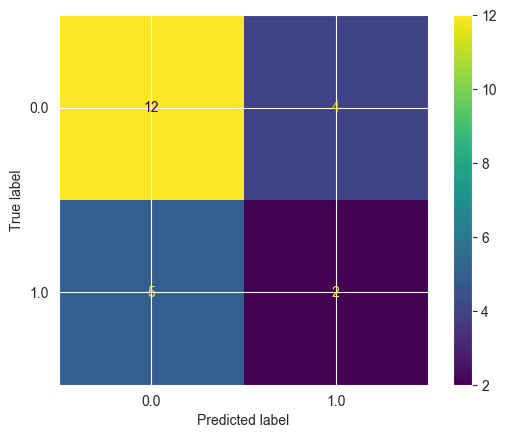

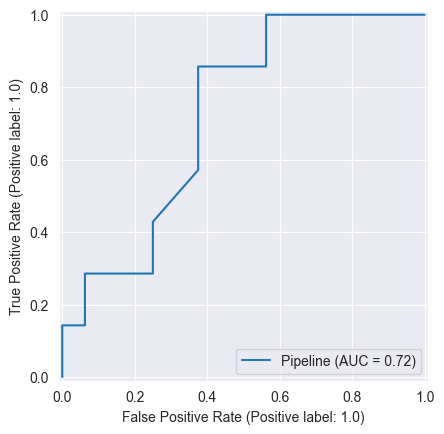

In [1]:
# **PCOS Risk Prediction System**
### Optimized and Refactored Code
# **Import Libraries**

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             ConfusionMatrixDisplay, RocCurveDisplay)
import joblib
import gradio as gr

# **1. Data Loading & Preprocessing**
# Load dataset

df = pd.read_csv("input/Cleaned-Data.csv")

# Clean target variable

df['PCOS'] = df['PCOS'].str.strip().map({'Yes': 1, 'No': 0})

# Calculate BMI first

df['BMI'] = df['Weight_kg'] / ((df['Height_ft'] * 0.3048) ** 2)


# Clean Age Column

def clean_age(age):
    if isinstance(age, str):
        parts = age.split('-')
        if len(parts) == 2:
            try:
                return (float(parts[0]) + float(parts[1])) / 2
            except ValueError:
                return np.nan
        else:
            return np.nan
    return age


df['Age'] = df['Age'].apply(clean_age)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop rows with NaN in Age or target variable (PCOS)
df.dropna(subset=['Age', 'PCOS'], inplace=True)

# Select clinically relevant features

FEATURES = [
    'Age',
    'BMI',
    'Family_History_PCOS',
    'Menstrual_Irregularity',
    'Hormonal_Imbalance',
    'Hirsutism',
    'Insulin_Resistance',
    'Exercise_Frequency',
    'Sleep_Hours',
    'Stress_Level'
]

TARGET = 'PCOS'

data = df[FEATURES + [TARGET]].copy()

# **2. Feature Engineering**
# Calculate BMI using existing height/weight

# Calculate BMI using existing height/weight
df['BMI'] = df['Weight_kg'] / ((df['Height_ft'] * 0.3048) ** 2)

# After calculating BMI, drop the original columns as they are no longer needed
df.drop(['Weight_kg', 'Height_ft'], axis=1, inplace=True)

# Convert categorical features

CATEGORICAL_FEATURES = ['Family_History_PCOS', 'Menstrual_Irregularity',
                        'Hormonal_Imbalance', 'Hirsutism', 'Insulin_Resistance',
                        'Stress_Level']
NUMERICAL_FEATURES = ['BMI', 'Age']

ORDINAL_FEATURES = {
    'Exercise_Frequency': ['Never', 'Rarely', '1-2 Times a Week',
                           '3-4 Times a Week', 'Daily'],
    'Sleep_Hours': ['Less than 6 hours', '6-8 hours', '9-12 hours', 'More than 12 hours']  # Added category here
}

# **3. Preprocessing Pipeline**
# Apply OrdinalEncoder for ordinal features

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=[ORDINAL_FEATURES['Exercise_Frequency'], ORDINAL_FEATURES['Sleep_Hours']])

# Column transformer for different feature types

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(drop='first'), CATEGORICAL_FEATURES),
        ('ord', ordinal_encoder, ['Exercise_Frequency', 'Sleep_Hours'])
    ]
)

# Full pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# **4. Train-Test Split**

# Remove rows where the target variable 'PCOS' is NaN
data_cleaned = data.dropna(subset=[TARGET])

# Now split the data into features (X) and target (y)
X = data_cleaned.drop(TARGET, axis=1)
y = data_cleaned[TARGET]

# Proceed with the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **5. Model Training with Grid Search**

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

print(f"Best Model Accuracy: {grid_search.best_score_:.2f}")

# **6. Model Evaluation**

y_pred = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
RocCurveDisplay.from_estimator(best_model, X_test, y_test)

# **7. Save Model & Preprocessor**

# Save the trained model to a file
joblib.dump(best_model, 'pcos_model.pkl')

# **8. Gradio Prediction Interface**

model = joblib.load('pcos_model.pkl')


def predict_pcos(
        Age: float,
        Weight_kg: float,
        Height_ft: float,
        Family_History_PCOS: str,
        Menstrual_Irregularity: str,
        Hormonal_Imbalance: str,
        Hirsutism: str,
        Insulin_Resistance: str,
        Exercise_Frequency: str,
        Sleep_Hours: str,
        Stress_Level: str
) -> tuple:
    """Predict PCOS risk with clinical features."""

    # Create input DataFrame
    input_df = pd.DataFrame([{
        'Age': Age,
        'Weight_kg': Weight_kg,
        'Height_ft': Height_ft,
        'Family_History_PCOS': Family_History_PCOS,
        'Menstrual_Irregularity': Menstrual_Irregularity,
        'Hormonal_Imbalance': Hormonal_Imbalance,
        'Hirsutism': Hirsutism,
        'Insulin_Resistance': Insulin_Resistance,
        'Exercise_Frequency': Exercise_Frequency,
        'Sleep_Hours': Sleep_Hours,
        'Stress_Level': Stress_Level
    }])

    # Calculate BMI
    input_df['BMI'] = input_df['Weight_kg'] / ((input_df['Height_ft'] * 0.3048) ** 2)
    input_df.drop(['Weight_kg', 'Height_ft'], axis=1, inplace=True)

    # Make prediction
    proba = model.predict_proba(input_df)[0][1]

    # Return the PCOS risk probability and the clinical recommendation as separate outputs
    return f"{proba * 100:.1f}%", "Consult Endocrinologist" if proba > 0.5 else "Maintain Healthy Lifestyle"


# Create interface
inputs = [
    gr.Number(label="Age", minimum=15, maximum=50),
    gr.Number(label="Weight (kg)", minimum=30, maximum=200),
    gr.Number(label="Height (ft)", minimum=4.5, maximum=6.5),
    gr.Dropdown(["Yes", "No"], label="Family History of PCOS"),
    gr.Dropdown(["Yes", "No"], label="Menstrual Irregularity"),
    gr.Dropdown(["Yes", "No"], label="Hormonal Imbalance"),
    gr.Dropdown(["Yes", "No"], label="Hirsutism (Excess Hair Growth)"),
    gr.Dropdown(["Yes", "No"], label="Insulin Resistance"),
    gr.Dropdown(ORDINAL_FEATURES['Exercise_Frequency'],
                label="Exercise Frequency"),
    gr.Dropdown(ORDINAL_FEATURES['Sleep_Hours'],
                label="Average Sleep Duration"),
    gr.Dropdown(["Yes", "No"], label="Chronic Stress")
]

interface = gr.Interface(
    fn=predict_pcos,
    inputs=inputs,
    outputs=[gr.Label(label="PCOS Risk Assessment"),
             gr.Label(label="Clinical Guidance")],
    title="PCOS Risk Prediction System",
    description="Assess polycystic ovary syndrome risk based on clinical and lifestyle factors",
    allow_flagging="never"
)

# **9. Launch Application**

if __name__ == "__main__":
    interface.launch(debug=True, inline=True, share=True)
